# Batsman Form Exploration

This is to explore any patterns in batsman's performance in consecutive matches. Eg: If a batsman scores a duck in the previous match will that affect the current performance

In [2]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../Data/selected_data/processed_data.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217242 entries, 0 to 217241
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   batter               217242 non-null  object 
 1   bowler               217242 non-null  object 
 2   non_striker          217242 non-null  object 
 3   runs_by_bat          217242 non-null  int64  
 4   extra_runs           217242 non-null  int64  
 5   total_runs_delivery  217242 non-null  int64  
 6   current_team_total   217242 non-null  int64  
 7   runs_remain          217242 non-null  float64
 8   batter_runs          217242 non-null  int64  
 9   balls_faced          217242 non-null  int64  
 10  wickets_fallen       217242 non-null  int64  
 11  extra_type           217242 non-null  object 
 12  delivery             217242 non-null  float64
 13  over                 217242 non-null  int64  
 14  wicket_type          217242 non-null  object 
 15  player_out       

In [33]:
data['date']  = data['match_id'].apply(lambda x: x[-10: ])
data.head()

,batter,bowler,non_striker,runs_by_bat,extra_runs,total_runs_delivery,current_team_total,runs_remain,batter_runs,balls_faced,...,winning_team,batting_team,bowling_team,won,final_team_total,batter_type,non_striker_type,bowler_type,replacements,date
0,AJ Finch,SL Malinga,M Klinger,0,0,0,0,-1.0,0,1,...,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,2017-02-17
1,AJ Finch,SL Malinga,M Klinger,0,0,0,0,-1.0,0,2,...,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,2017-02-17
2,AJ Finch,SL Malinga,M Klinger,1,0,1,1,-1.0,1,3,...,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,2017-02-17
3,M Klinger,SL Malinga,AJ Finch,2,0,2,3,-1.0,2,1,...,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,2017-02-17
4,M Klinger,SL Malinga,AJ Finch,0,0,0,3,-1.0,2,2,...,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,2017-02-17


In [36]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2]) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (
		    data['innings'].isin(innings))
	]

	player_data.head()

	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = ['date', 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over',
	    'delivery', 'wickets_fallen', 'bowling_team', 'batting_team', 'venue', 'toss_winner', 'batter_type', 'non_striker_type']
	player_scores = gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery',
	                      'wickets_fallen', 'current_team_total']]
	first_ball['first_ball'] = (
	    first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']
	player_scores['current_team_total'] = first_ball['current_team_total']

    # convert toss win to boolean
	player_scores['toss_winner'] = (
	    player_scores['toss_winner'] == player_scores['batting_team']).astype(int);

    # when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker']
	    == player_name].index

	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, [
	    'batter_runs', 'balls_faced']] = [0, 0]

	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (
	    player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]

	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)

	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(
	    player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (
	    player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)

	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs',
	    'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 +
	                          matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis=1)

	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]

		if player_data.empty:
			return player_data.drop('match_id', axis=1)

		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced

		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop(
		    'match_id', axis=1)  # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby(
	    'match_id')['bowler_type'].value_counts().unstack(fill_value=0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(
	    remaining_ball_types, how='left', on='match_id')

	player_scores.fillna(0, inplace=True)
	
    
    # if batsman ended as non_striker, make him the batter and drop the nonstriker column
	player_scores['batter'] = player_name
	player_scores.drop('non_striker', inplace=True, axis = 1)

	# Sort according to date
	player_scores.sort_values(by='date', inplace=True)

	return player_scores




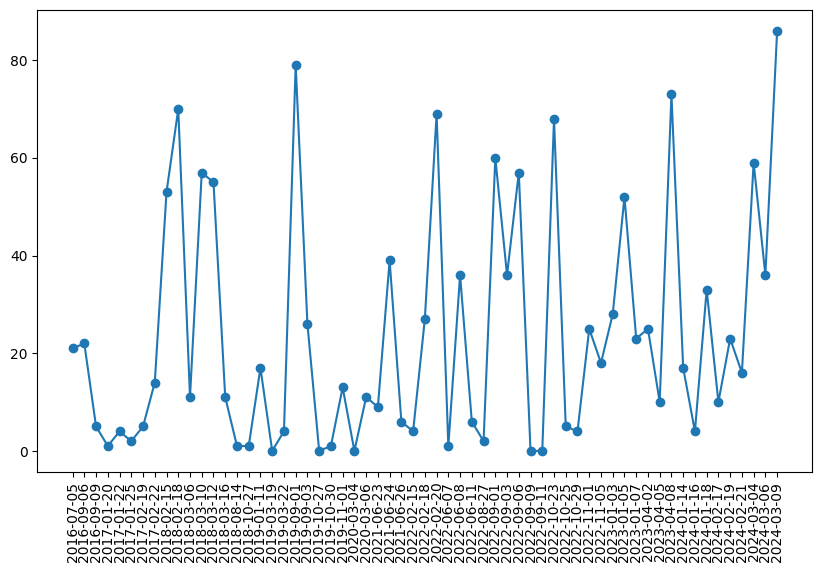

In [49]:
import matplotlib.pyplot as plt

kusal_mendis_df = getPlayerScores('BKG Mendis')[['date', 'batter_runs', 'balls_faced', 'won']]

plt.figure(figsize=(10, 6))
plt.plot(kusal_mendis_df['date'], kusal_mendis_df['batter_runs'], marker='o')
plt.xticks(rotation=90)
plt.show()